In [1]:
%load_ext autoreload

In [2]:
%autoreload

import sys
sys.path.append('..')

import os
import re
import csv

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import color.data.colors_big as dataset

In [3]:
# Choose embedding file
datasets_path = os.path.join('..', 'datasets')
emb_dir = os.path.join(datasets_path, 'embeddings')
emb_files = [os.path.join(emb_dir, f) for f in os.listdir(emb_dir)]
emb_dims = 50 # 50, 100, 200, 300
emb_file = list(filter(lambda f: str(emb_dims) in f, emb_files))[0]
emb_file

'../datasets/embeddings/glove.6B.50d.txt'

In [16]:
# Parse embeddings
emb_df = pd.read_csv(emb_file, sep=' ', engine='c', encoding='utf-8',
                     quoting=csv.QUOTE_NONE, header=None,
                     keep_default_na=False, na_values=['%%%&&&???@@@'])
vocab = emb_df[0]
emb_df.drop(0, axis=1, inplace=True)
emb_matrix = emb_df.astype('float').values
emb_dict = {vocab[i]: emb_matrix[i] for i in range(len(vocab))}

emb_matrix.shape

(400000, 50)

In [7]:
# Embedding Characters
emb_words = set(vocab)
emb_chars = set()
for word in emb_words:
    for char in word:
        emb_chars.add(char)
len(emb_words), len(emb_chars)

(400000, 489)

In [8]:
# Extract words from color names
color_words = set()
color_names, color_rgb = dataset.load_color_names()
print('Color map:', color_rgb.shape)
for name in color_names:
    for comps in name.split():
        color_words.add(comps.lower())
len(color_words)

Color map: (18081, 3)


9807

In [10]:
# Color names characters
color_chars = set()
for word in color_words:
    for char in word:
        color_chars.add(char)
len(color_chars)

90

In [11]:
# Overlaps
common_words = color_words & emb_words
print('Common Words: {} [{:.2f}%]'.format(len(common_words), len(common_words)*100/len(color_words)))

common_chars = color_chars & emb_chars
print('Common Characters: {} [{:.2f}%]'.format(len(common_chars), len(common_chars)*100/len(color_chars)))

print('Missing Words (50):')
print(list(color_words - emb_words)[:50])

print('Missing Characters:')
print(list(color_chars - emb_chars))


Common Words: 8300 [84.63%]
Common Characters: 88 [97.78%]
Missing Words (50):
['apium', 'greenday', "bugman's", "o'doon", 'earthshade', 'aijiro', 'imayou', 'duqqa', 'funkie', "duck's", 'peachade', 'juneberry', "cow's", 'supermint', 'scarabœus', 'tainoi', 'brick-a-brack', 'kōbai', 'myoga', 'mizuasagi', 'tambua', 'so-sari', 'uguisu', 'dechala', 'grauzone', 'sylvaneth', 'kincha', "dhalsim's", 'indocile', 'fioletowyi', "mary's", 'greyed', 'jabłoński', 'goldspar', 'sugar-candied', 'amphystine', 'porcellana', 'sauterne', 'rapakivi', 'jadesheen', 'xereus', 'windflower', "gentleman's", 'hygge', 'cadian', 'mindaro', 'feldgrau', 'pipitschah', 'nymphaeaceae', 'ōtan']
Missing Characters:
['ǎ', 'ǜ']


In [13]:
# Get embeddings for words
# For known words (which have embeddings) just lookup the embedding
# For any other word, generate a random embedding
known_words = ['red', 'black', 'peachy', 'watermelon', 'dog']
unknown_words = ['sussie', 'truesky', "elmer's", 'skavenblight', "bunny's"]
for word in [*known_words, *unknown_words]:
    if word in emb_dict:
        known = True
        emb = np.array(emb_dict[word])
    else:
        known = False
        emb = np.random.rand(emb_dims) - 0.5  # Range (-0.5, 0.5)
    print("Word: {}, Known: {}, Emb Shape: {}\nEmbedding: {}".format(word, known, emb.shape, emb[:5]))

Word: red, Known: True, Emb Shape: (50,)
Embedding: [-0.12878  0.8798  -0.60694  0.12934  0.5868 ]
Word: black, Known: True, Emb Shape: (50,)
Embedding: [-0.96256  0.65329 -0.55152 -0.41065  0.80223]
Word: peachy, Known: True, Emb Shape: (50,)
Embedding: [ 0.0057898  0.71833   -0.60716   -0.6716     0.21509  ]
Word: watermelon, Known: True, Emb Shape: (50,)
Embedding: [-0.11169 -0.73634 -0.87099  0.66481  0.8636 ]
Word: dog, Known: True, Emb Shape: (50,)
Embedding: [ 0.11008 -0.38781 -0.57615 -0.27714  0.70521]
Word: sussie, Known: False, Emb Shape: (50,)
Embedding: [ 0.24505987  0.39123723 -0.1576074   0.26635856  0.21380343]
Word: truesky, Known: False, Emb Shape: (50,)
Embedding: [ 0.13598183  0.17251403  0.41539373 -0.4778686  -0.38185282]
Word: elmer's, Known: False, Emb Shape: (50,)
Embedding: [ 0.07774902 -0.14148335 -0.13175237 -0.21816798  0.14840148]
Word: skavenblight, Known: False, Emb Shape: (50,)
Embedding: [ 0.04454235 -0.42066435 -0.07984776 -0.43807223 -0.27561507]
Wor

In [19]:
# Check similarity b/w words
def similarity(x, y):
    return np.dot(x, y.T) / (np.sqrt(np.dot(x, x.T)) * np.sqrt(np.dot(y, y.T)))

words = [
    ['woman', 'kitchen'],
    ['woman', 'object'],
    ['woman', 'woman'],
]
for word1, word2 in words:
    emb1, emb2 = np.array(emb_dict[word1]), np.array(emb_dict[word2])
    print('Similarity b/w "{}" and "{}" is {}'.format(word1, word2, similarity(emb1, emb2)))

Similarity b/w "woman" and "kitchen" is 0.4181231013837278
Similarity b/w "woman" and "object" is 0.4139111260693676
Similarity b/w "woman" and "woman" is 1.0000000000000002


In [25]:
# Get closest words for embeddings

emb_red = np.array(['-0.12878', '0.8798', '-0.60694', '0.12934', '0.5868', '-0.038246', '-1.0408',
 '-0.52881', '-0.29563', '-0.72567', '0.21189', '0.17112', '0.19173', '0.36099',
 '0.032672', '-0.2743', '-0.19291', '-0.10909', '-1.0057', '-0.93901', '-1.0207',
 '-0.69995', '0.57182', '-0.45136', '-1.2145', '-1.1954', '-0.32758', '1.4921',
 '0.54574', '-1.0008', '2.845', '0.26479', '-0.49938', '0.34366', '-0.12574',
 '0.5905', '-0.037696', '-0.47175', '0.050825', '-0.20362', '0.13695', '0.26686',
 '-0.19461', '-0.75482', '1.0303', '-0.057467', '-0.32327', '-0.7712',
 '-0.16764', '-0.73835']).astype(np.float).reshape(50,1)  # Embedding for the word "red"

emb_random = np.random.rand(50) - 0.5  # Candidate for out of vocab words
emb_ones = np.ones_like(emb_red)  # Candidate for stop word

# Choose an embedding to compare
emb_curr = emb_red

# Similary score
embs_mag = np.sqrt(np.sum(emb_matrix*emb_matrix, axis=1)).reshape(-1)  # Norm of all word embeddings
emb_curr_mag = np.sqrt(np.dot(emb_curr.T, emb_curr)).reshape(-1)  # Norm of current word embedding
emb_dot = np.dot(emb_matrix, emb_curr).reshape(-1)  # Dot product of current embedding with all other embeddings
embs_sim = emb_dot / (embs_mag * emb_curr_mag)  # Cosine similary scores

# Most similar word
print('Most similar word:', vocab[np.argmax(embs_sim)], embs_sim[np.argmax(embs_sim)])

# Most dissimilar word
print('Most dissililar word', vocab[np.argmin(embs_sim)], embs_sim[np.argmin(embs_sim)])

Most similar word: red 0.9999999999999999
Most dissililar word esber -0.7445946751683283


In [26]:
# Lets sample out some words embeddings for the purpose of EDA
idx = np.arange(len(emb_dict))
np.random.shuffle(idx)
samp_size = 10000
samp = emb_matrix[idx[:samp_size]]
samp.shape

(10000, 50)

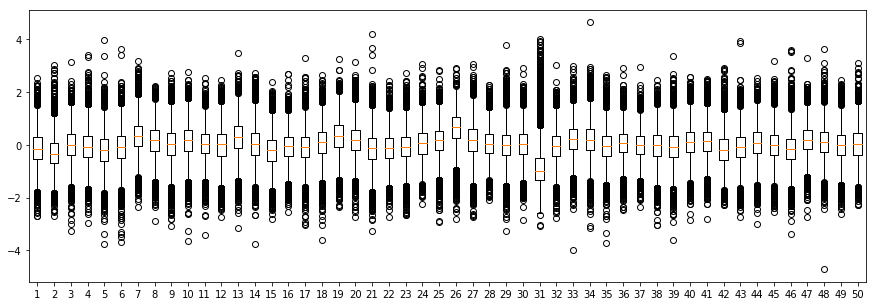

In [27]:
# Embedding Distribution
plt.figure(figsize=(15,5))
plt.boxplot(samp)
plt.show()

In [28]:
# Summary
df = pd.DataFrame(samp)
df.describe()

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,...,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,-0.134635,-0.299095,-0.000327,-0.053555,-0.190095,-0.081062,0.335491,0.158653,0.025852,0.169038,...,0.142787,-0.166992,-0.082603,0.076394,-0.001873,-0.136881,0.196144,0.112554,-0.000577,0.034321
std,0.635910,0.608739,0.613441,0.623570,0.641249,0.654232,0.621314,0.603905,0.645452,0.617290,...,0.573647,0.605136,0.613565,0.622578,0.624127,0.632823,0.554713,0.614274,0.596142,0.623750
min,-2.699000,-2.709900,-3.249300,-2.955300,-3.753500,-3.695100,-2.354100,-2.873400,-3.075300,-3.647500,...,-2.796900,-2.288500,-2.731600,-3.008400,-2.547600,-3.377200,-2.728200,-4.723100,-2.605800,-2.297100
25%,-0.547473,-0.687795,-0.395942,-0.464255,-0.604840,-0.484195,-0.056260,-0.215930,-0.372120,-0.217858,...,-0.219455,-0.561090,-0.476685,-0.317035,-0.392948,-0.529400,-0.153005,-0.274097,-0.374720,-0.377687
50%,-0.143585,-0.328445,0.002131,-0.078585,-0.191000,-0.074201,0.343465,0.186090,0.038492,0.188140,...,0.140805,-0.197585,-0.090257,0.084636,-0.006320,-0.157735,0.200245,0.123245,-0.011223,0.020276
75%,0.279998,0.065015,0.400280,0.333742,0.214948,0.339702,0.730032,0.565990,0.437415,0.572185,...,0.496792,0.203187,0.304060,0.488125,0.389962,0.232900,0.556870,0.489743,0.382083,0.438950
max,2.540200,3.034400,3.122400,3.397000,3.965200,3.632300,3.184600,2.242400,2.720200,2.759700,...,2.483200,2.927000,3.948300,2.550600,3.169600,3.579700,3.292700,3.644400,2.464800,3.118000


In [29]:
print('IQR:', np.percentile(samp, 25), np.percentile(samp, 75))
print('Mean:', np.mean(samp))

IQR: -0.38755 0.4376625
Mean: 0.0216438756894786
